# SEELK HACKATHON: THE BUY BOX

<p> <strong>Author</strong>: Ruben Poretz</p>
<p><strong>Date</strong>: 11/18/2019</p>

##  I - Imports

In [2]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize
import re
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

## II - Loading the data set

In [3]:
data = pd.read_csv('data.csv' , sep=';')
data.head()

,offer,scraping_date,buy_box_owner,owner_merchant_id,price_currency,delivery_details,condition,seller_name,rating_text,products_details,fba_text,add_to_basket,url,offer_ranking,merchant_id,shipping_cost,is_global_store,is_prime
0,7247,2018-05-31,Verkauf und Versand durch Die NaturApotheke. F...,A2YQFBJ9TJXWZ0,"EUR 19,17","+ EUR 3,95 Versandkosten",Neu,Die NaturApotheke,5 von 5 Sternen 98% positiv in den letzten 12 ...,['Lieferung erfolgt 6.-8. Juni. Weitere Inform...,None,In den Einkaufswagen von Verkäufer Die NaturAp...,https://www.amazon.de/gp/offer-listing/B000M45...,1,A2YQFBJ9TJXWZ0,"EUR 3,95",False,False
1,375109,2018-05-31,Verkauf und Versand durch Amazon. Geschenkverp...,1,"EUR 17,50","+ EUR 17,90 Versandkosten",Neu,PICCOLO,5 von 5 Sternen 100% positiv in den letzten 12...,['Lieferung erfolgt 8.-13. Juni. Weitere Infor...,None,In den Einkaufswagen von Verkäufer PICCOLO und...,https://www.amazon.de/gp/offer-listing/B00AUV7...,9,A1OJ6JQSEK83CV,"EUR 17,90",False,False
2,375109,2018-05-31,Verkauf und Versand durch Amazon. Geschenkverp...,1,"EUR 20,09","+ EUR 13,06 Versandkosten",Neu,Brikoland,3 von 5 Sternen 57% positiv in den letzten 12 ...,['Lieferung erfolgt 13.-18. Juni. Weitere Info...,None,In den Einkaufswagen von Verkäufer Brikoland u...,https://www.amazon.de/gp/offer-listing/B00AUV7...,8,A14OYWBRW8YQ5Q,"EUR 13,06",False,False
3,375109,2018-05-31,Verkauf und Versand durch Amazon. Geschenkverp...,1,"EUR 22,90","+ EUR 10,00 Versandkosten",Neu,Qualazampapetshop,"4,5 von 5 Sternen 86% positiv. (7 alle Bewertu...",['Lieferung erfolgt 15.-20. Juni. Weitere Info...,None,In den Einkaufswagen von Verkäufer Qualazampap...,https://www.amazon.de/gp/offer-listing/B00AUV7...,7,A1H4RFP0B0FMHY,"EUR 10,00",False,False
4,375109,2018-05-31,Verkauf und Versand durch Amazon. Geschenkverp...,1,"EUR 20,34","+ EUR 11,90 Versandkosten",Neu,Initpc,4 von 5 Sternen 79% positiv. (39 alle Bewertun...,['Lieferung erfolgt 8.-13. Juni. Weitere Infor...,None,In den Einkaufswagen von Verkäufer Initpc und ...,https://www.amazon.de/gp/offer-listing/B00AUV7...,6,A1VCQKXS62I5R,"EUR 11,90",False,False


## III - First Analysis

First I show the types of our features

In [4]:
data.dtypes

offer                 int64
scraping_date        object
buy_box_owner        object
owner_merchant_id    object
price_currency       object
delivery_details     object
condition            object
seller_name          object
rating_text          object
products_details     object
fba_text             object
add_to_basket        object
url                  object
offer_ranking         int64
merchant_id          object
shipping_cost        object
is_global_store        bool
is_prime               bool
dtype: object

Then I print some of the features with unique values to discover more of our data

In [5]:
#find all different scrapping dates
pd.unique(data['scraping_date'])

array(['2018-05-31', '2018-05-30', '2018-05-29', '2018-05-28',
       '2018-05-27', '2018-05-26', '2018-05-25', '2018-05-24',
       '2018-05-23', '2018-05-22', '2018-05-21', '2018-05-20',
       '2018-05-19', '2018-05-18', '2018-05-17', '2018-05-16',
       '2018-05-15', '2018-05-14', '2018-05-13', '2018-05-12',
       '2018-05-11', '2018-05-10', '2018-05-09', '2018-05-08',
       '2018-05-03', '2018-05-02', '2018-05-01', '2018-04-30',
       '2018-04-29'], dtype=object)

In [6]:
#Find all different offers "id"
pd.unique(data['offer'])

array([   7247,  375109, 1584523, ...,   26572,    9074,    9232],
      dtype=int64)

In [7]:
#Find the different seller names
pd.unique(data['seller_name'])

array(['Die NaturApotheke', 'PICCOLO', 'Brikoland', ..., 'POLKA WEB',
       '5 Star Offers', 'INGROSCART srl'], dtype=object)

In [8]:
data['price_currency'].unique()

array(['EUR 19,17', 'EUR 17,50', 'EUR 20,09', ..., 'EUR 80,61', '£206.97',
       'EUR 1,78'], dtype=object)

In [9]:
#Shipping cost values, see some problems we will have to treat
print("First values with 'None':",data['shipping_cost'][:8])
print("Example of problematic value:",data['shipping_cost'][547160])

First values with 'None': 0     EUR 3,95
1    EUR 17,90
2    EUR 13,06
3    EUR 10,00
4    EUR 11,90
5    EUR 10,33
6     EUR 8,90
7         None
Name: shipping_cost, dtype: object
Example of problematic value: £1.95


In [10]:
# Find all conditions
data['condition'].unique()

array(['Neu', 'Nuovo', 'New', 'Nuevo', 'Neuf', nan,
       'Certified Refurbished'], dtype=object)

In [11]:
#Find all different 'is_prime' values
data['is_prime'].unique()

array([False,  True])

In [12]:
# Sow the different values in fba_text
data['fba_text'].unique()

array(['None', 'Spedito da Amazon', 'Fulfilled by Amazon',
       'Versand durch Amazon.de', 'EXPÉDIÉ PAR AMAZON',
       'Gestionado por Amazon', 'Fulfillment by Amazon'], dtype=object)

## IV - Data Cleaning

In [13]:
#Columns I will create for cleaning

# 1) Price currency
data.insert(4,'currency','')

#2) Rating_text
data.insert(8,'rating_value','')
data.insert(9,'rating_percentage','')
data.insert(10,'total_voters','')

# 3) Finding the buy_bow winners
data.insert(2,'is_winner','')

### A) Cleaning of  price_currency, shipping_cost, rating text, buy_box_owner, condition and fba_text columns

I do all the cleaning in the same loop to improve the algorithm computing time. In the following loop, we put some nan values depending on the cases. We will handle this in the modeling part (V)

In [14]:
                        '''1) Cleaning of the price_currency column and shipping_cost column '''

#Replace commas by points
data['price_currency']=data['price_currency'].str.replace(',','.')
data['price_currency']=data['price_currency'].str.replace('EUR','€')
price_currency=data['price_currency']

#Remove the currency on shipping_cost
data['shipping_cost']=data['shipping_cost'].str.replace(',','.')
data['shipping_cost']=data['shipping_cost'].str.replace('EUR','€')
data['shipping_cost']=data['shipping_cost'].str.replace('None','00.00')
shipping_cost=data['shipping_cost']

#Create empty lists  I use after
l_price_currency=[]
l_currency=[]
l_shipping_cost=[]
#Pattern I use in our regex expressions
patterncur = '^(\d|.)'

"""----------------------------------------------------------------------------------------------------------------------
                                    2) Cleaning of the 'rating_text' column"""
#Regex patterns
patternrate = '\d\.\d+|\d\,\d+|\d'
patternper='\d+\%'

#Creating the lists
l21=[]
l22=[]
l_rating_value=[]
l_rating_per=[]
l_rating_total_voters=['']*data.shape[0]

"""----------------------------------------------------------------------------------------------------------------------
                                    3) Finding if a merchant is the buy_box winner"""
#Creating the lists
l_owner_merchant_id=data['owner_merchant_id']
l_merchant_id=data['merchant_id']
l_is_winner=['']*data.shape[0]

"""----------------------------------------------------------------------------------------------------------------------
                                    4) Transform conditions to bool for better data handling"""

#Code for conditions: True: New, False: Certified Refurbished, nan: nan 
l_condition=data['condition']
l_condition_unique=data['condition'].unique()
l_condition_unique2=np.delete(l_condition_unique, [5,6], None)
l_condition_final=[]

"""----------------------------------------------------------------------------------------------------------------------
                          5) changing fba_text column to bool wether it's fulfilled by Amazon or not"""

l_fba_text=data['fba_text']
#As seen before only the first value in data['condition'].unique() is 'None'. This is also the only 'different' one among all the others (they're giving the same information, fba, but in different languages)
#That is why I create l_fba_text_unique2: Detect 'fba' values easily 
l_fba_text_unique=data['fba_text'].unique()
l_fba_text_unique2=np.delete(l_fba_text_unique, [0], False)
l_fba_text_final=[]

"""---------------------------------------------------LOOP-------------------------------------------------------------------"""

for i in range(data.shape[0]):
    
    '''             1)Cleaning of the price_currency column and shipping_cost colum '''
    
    #I use regex expressions to find the price, the currency and the shipping cost
    cur = re.match(patterncur,str(price_currency[i]))
    val_price=re.sub(patterncur,'',str(price_currency[i]))
    val_shipping_cost=re.sub(patterncur,'',str(shipping_cost[i]))
    l1=[]
    ll1=[]
    
    # Finding only the digits and '.' separating decimals. I do it for the prices and shipping costs
    for m in re.finditer('\.', val_price):
        l1.append(m.start(0))
    lenm=len(l1)-1  
    val_price=val_price.replace('.','',lenm)
    
    for m1 in re.finditer('\.', val_shipping_cost):
        ll1.append(m1.start(0))
    lenm1=len(ll1)-1  
    val_shipping_cost=val_shipping_cost.replace('.','',lenm1)
    
    
    l_currency.append(cur[0])
    l_price_currency.append(val_price)
    l_shipping_cost.append(val_shipping_cost)
    """----------------------------------------------------------------------------------------------------------------------
                                    2) Cleaning of the 'rating_text' column"""
    #I use the NLTK library to separate the text in rating_text (create two tokens, cutting at each end of sentence)
    l_token=sent_tokenize(data.at[i,'rating_text'])
    
    # In most of the cases, the len of l_token is equal to 2. In the first token is put the rating on 5 and the percentage of positive votes.
    #In the second token I put the number of voters. Then I append each tokens in lists and use regex expressions to find the desired values.
    if len(l_token)==2:
        l21.append(l_token[0])
        l22.append(l_token[1])
        
    #Here I handle case where  the number of voters is missing initially in the data.
    else :
        l21.append(l_token[0])
        l22.append('None')
        
    #Find the ratings (on 5) using Regex    
    val_rating = re.match(patternrate,l21[i])
    if val_rating.__class__.__name__=='NoneType':
        l_rating_value.append('None')
    else:
        l_rating_value.append(val_rating[0])
        #Treating values
        l_rating_value[i]=l_rating_value[i].replace(',','.')
    
    #Find the % of positive votes sing Regex    
    val_per = re.findall(patternper,l21[i])
    if len(val_per)==0:
        l_rating_per.append('None')
    else:
        l_rating_per.append(val_per[0])
        #Retrieving the '%' sign, I want to have values between 0 and 1, I normalize this later
        l_rating_per[i]=str(l_rating_per[i]).replace('%','')

    
    #Find the total number of voters unsing Regex
    splitted=l22[i].split()
    if splitted[0]=='None':
        splitted[0]='0'
    l_rating_total_voters[i]= splitted[0]
    #Treating the values to have float type of values in the list, then I assign the list to the column after
    l_rating_total_voters[i]=l_rating_total_voters[i].replace('(','')
    l_rating_total_voters[i]=l_rating_total_voters[i].replace(',','')
    l_rating_total_voters[i]=l_rating_total_voters[i].replace('.','')
    l_token=[]
    
    """----------------------------------------------------------------------------------------------------------------------
                                    3) Finding if a merchant is the buy_box winner"""
    # Put boolean values in the column "is_winner" that I created before. This is the labels of our model
    if l_owner_merchant_id[i]==l_merchant_id[i]:
        l_is_winner[i]=True
    else:
        l_is_winner[i]=False
    """----------------------------------------------------------------------------------------------------------------------
                                    4) Transform conditions to bool for better data handling"""
    #code for conditions: True: New (for all languages found in data['condition'].unique()), False: Certified Refurbished, nan: nan 
    if l_condition[i] in l_condition_unique2:
        l_condition_final.append(True)   
    if str(l_condition[i]) == 'Certified Refurbished':
        l_condition_final.append(False) 

    if str(l_condition[i]) == 'nan':
        l_condition_final.append('nan') 
        
    """----------------------------------------------------------------------------------------------------------------------
                          5) changing fba_text column to bool wether it's fulfilled by Amazon or not"""
   
    if l_fba_text[i] in l_fba_text_unique2:
        l_fba_text_final.append(True)
    else :
        l_fba_text_final.append(False)        

"""----------------------------Treating lists and assigning them to the correct columns--------------------------------------"""
                        
                        '''1)Cleaning of the price_currency column and shipping_cost column '''
#Asserting prices and shipping costs to be floats, The None values are treated in part V
l_price_currency= [None if i == "one" else float(i) for i in l_price_currency]
l_shipping_cost= [None if i == "one" else float(i) for i in l_shipping_cost]

data['currency']=l_currency
data['price_currency']=l_price_currency
data['shipping_cost']=l_shipping_cost


"""----------------------------------------------------------------------------------------------------------------------
                                    2) Cleaning of the 'rating_text' column"""

#Conversion of the lists into float and assignment the arrays to the corresponding columns
l_rating_value=[None if i == "None" else float(i) for i in l_rating_value]
data['rating_value']=l_rating_value

l_rating_per=[None if i == "None" else float(i) for i in l_rating_per]
data['rating_percentage']=l_rating_per
data['rating_percentage']=data['rating_percentage']*0.01

l_rating_total_voters=[None if i == "None" else float(i) for i in l_rating_total_voters]
data['total_voters']=l_rating_total_voters

"""----------------------------------------------------------------------------------------------------------------------
                                    3) Finding if a merchant is the buy_box winner"""

data['is_winner']=l_is_winner

"""----------------------------------------------------------------------------------------------------------------------
                                    4) Transform conditions to bool for better data handling"""
data['condition']=l_condition_final
#I Change the type of condition to boolean
data['condition']=data['condition'].astype(bool)

"""----------------------------------------------------------------------------------------------------------------------
                          5) Changing fba_text column to bool wether it's fulfilled by Amazon or not"""

data['fba_text']=l_fba_text_final

### 6) Changing scraping_date type to datetime

In [15]:
data['scraping_date']=data['scraping_date'].astype('datetime64[D]',format='%Y-%m-%d')

### B) Renaming some columns and print the datatypes 

In [16]:
data.rename(columns={'price_currency':'price','fba_text':'is_fba'},inplace=True)

In [17]:
data.dtypes

offer                         int64
scraping_date        datetime64[ns]
is_winner                      bool
buy_box_owner                object
owner_merchant_id            object
currency                     object
price                       float64
delivery_details             object
condition                      bool
rating_value                float64
rating_percentage           float64
total_voters                float64
seller_name                  object
rating_text                  object
products_details             object
is_fba                         bool
add_to_basket                object
url                          object
offer_ranking                 int64
merchant_id                  object
shipping_cost               float64
is_global_store                bool
is_prime                       bool
dtype: object

## V - Create the Model

**OBJECTIVE:** Predict for each offer if a seller is the buy_bow winner.

$Features:$ Some are **continous** (price, shipping_cost, rating, total_voters), some are **discrete** (the boolean columns such as is_prime,condition,etc.)

$Labels:$ is_winner (**discrete** and **binary**)

## This is a Supervised Learning problem: Binary Classification

## I chose to implement a random forest classifier. 

A random forest classifier creates a large number of decision trees on randomly selected data samples (doing bagging),then gets prediction from each tree and selects the best solution by mode (largest number of label predictions). The fact to use the ensemble predictions make it more accurate and efficient for our problem.



Random forest is also suitable for our problem because it outputs interpretable measures of feature importance (calculated as the average of the Gini index among all splits in the trees).

We use the **sklearn** library to develop our model.

### I choose some of the features:
- price
- Condition
- rating_value
- rating_percentage
- total_voters
- offer_ranking
- shipping_cost
- is_fba
- is_global_store
- is_prime


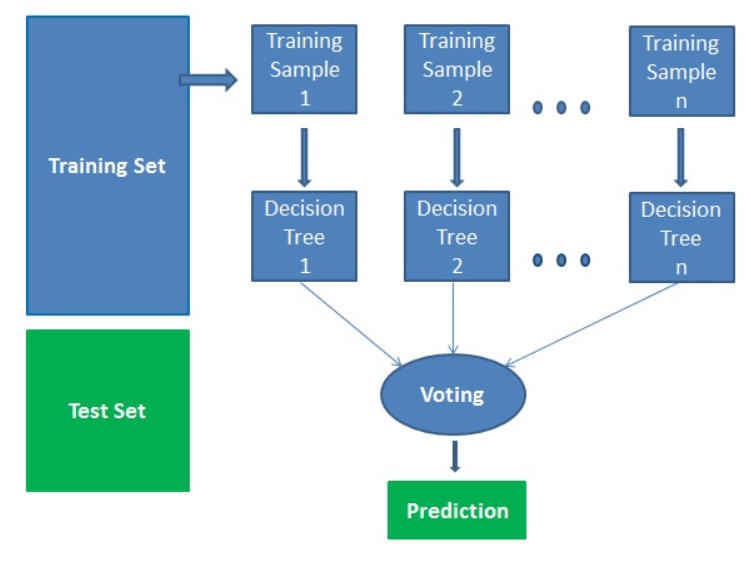

In [168]:
X=data[['price','condition','rating_value','rating_percentage','total_voters','offer_ranking','shipping_cost','is_fba','is_global_store','is_prime']]
#Random Forest cannot handle nan values : we change nan values in columns with means
X[ 'price' ].fillna(X[ 'price' ].mean() , inplace = True)
X[ 'rating_value' ].fillna(X[ 'rating_value' ].mean() , inplace = True)
X[ 'rating_percentage' ].fillna(X[ 'rating_percentage' ].mean() , inplace = True)
X[ 'total_voters' ].fillna(X[ 'total_voters' ].mean() , inplace = True)
X[ 'offer_ranking' ].fillna(X[ 'offer_ranking' ].mean() , inplace = True)
X[ 'shipping_cost' ].fillna(X[ 'shipping_cost' ].mean() , inplace = True)
X.head()

C:\Users\ruben\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,price,condition,rating_value,rating_percentage,total_voters,offer_ranking,shipping_cost,is_fba,is_global_store,is_prime
0,19.17,True,5.0,0.98,1876.0,1,3.95,False,False,False
1,17.50,True,5.0,1.00,1.0,9,17.90,False,False,False
2,20.09,True,3.0,0.57,54.0,8,13.06,False,False,False
3,22.90,True,4.5,0.86,7.0,7,10.00,False,False,False
4,20.34,True,4.0,0.79,39.0,6,11.90,False,False,False


**Define the size of training and testing samples:** 
- training:80%
- testing:20%

In [169]:
size = len(X)
training_size=int(0.8*size)
test_size=int(0.2*size)

X_train=X[:training_size]
X_test=X[training_size:training_size+test_size]
Y_train=data['is_winner'][:training_size]
Y_test=data['is_winner'][training_size:training_size+test_size]

## Parameters of the model

- **RSEED**: number of random states for decision trees. Set to 50.

- **boostrap**: do or not bagging with replacement (select the same value multiple times) in bags to train the model. I set it to 'True'. It will increase the variance for each decision tree but reduce it for the global model without affecting the bias.

- **n_estimators**: number of decision trees in our model.I take a huge number (100) but not to huge because it will lower our speed.

- **max_features**:The number of features to consider when looking for the best split. I choose sqrt (square root), it means it will take the square root of the number of features(10).
- **n_jobs**: number of jobs to run in parralel, use for computing optimization. Set to -1. It means that it will use all the processors of the computer.

- **verbose**: print (1) or not (0) updates while running the fitting and predicting functions. Set to 1.


### I create the model with the chosen parameters

In [170]:
RSEED = 50

# Creation of the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,random_state=RSEED,
                               max_features = 'sqrt',n_jobs=-1, verbose = 1)

###### I do the fitt and predict steps of our model and print some statistics: 
- average number of node (ie. size) per tree
- average maximum depth (length of the longest path from a root to a leaf.) per tree 

In [171]:
# Fit on training data
model.fit(X_train, Y_train)

n_nodes = []
max_depths = []
# Statistics about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

    

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train)
train_rf_probs = model.predict_proba(X_train)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.0s finished


Average number of nodes 18055
Average maximum depth 40


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.8s finished


In [172]:
# Actual class predictions
rf_predictions = model.predict(X_test)
# Probabilities for each class
rf_probs = model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


## VI - Evaluation of the model
I chose two metrics for the model evaluation:
- **roc curve**:  plot of the True Positive Rate (y-axis) against the False Positive Rate (x-axis).
- **Confusion Matrix**: a (2,2) matrix showing the number or percentage of correctly and not correctly predicted values.

I choose those metrics because they are relevant for prediction problems with binar classification. Because it is an imbalanced classification problem, accuracy is not appropriate for evaluating our model. I print it just for information below.

In [173]:
print("training accuracy:",accuracy_score(train_rf_predictions,Y_train),"testing accuracy:",accuracy_score(rf_predictions,Y_test))

training accuracy: 0.9952735579668761 testing accuracy: 0.9750084523515813


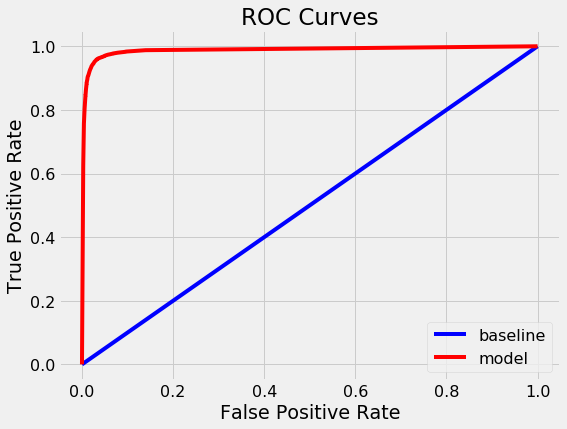

In [174]:
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(Y_test, 
                                     [1 for _ in range(len(Y_test))])
    baseline['precision'] = precision_score(Y_test, 
                                      [1 for _ in range(len(Y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(Y_test, predictions)
    results['precision'] = precision_score(Y_test, predictions)
    results['roc'] = roc_auc_score(Y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(Y_train, train_predictions)
    train_results['precision'] = precision_score(Y_train, train_predictions)
    train_results['roc'] = roc_auc_score(Y_train, train_probs)
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(Y_test, [1 for _ in range(len(Y_test))])
    model_fpr, model_tpr, _ = roc_curve(Y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Normalized confusion matrix


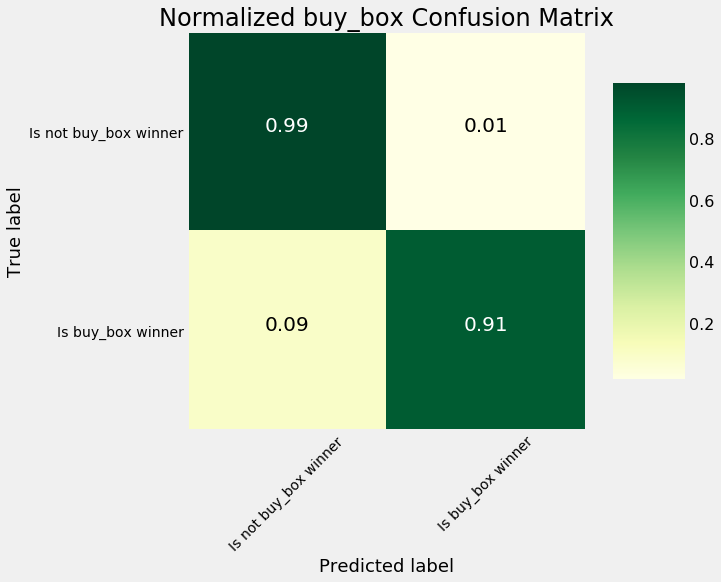

In [175]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.YlGn):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Normalized confusion matrix
cm = confusion_matrix(Y_test, rf_predictions)
plot_confusion_matrix(cm, classes = ['Is not buy_box winner', 'Is buy_box winner'],
                      title = 'Normalized buy_box Confusion Matrix')


Confusion matrix, without normalization


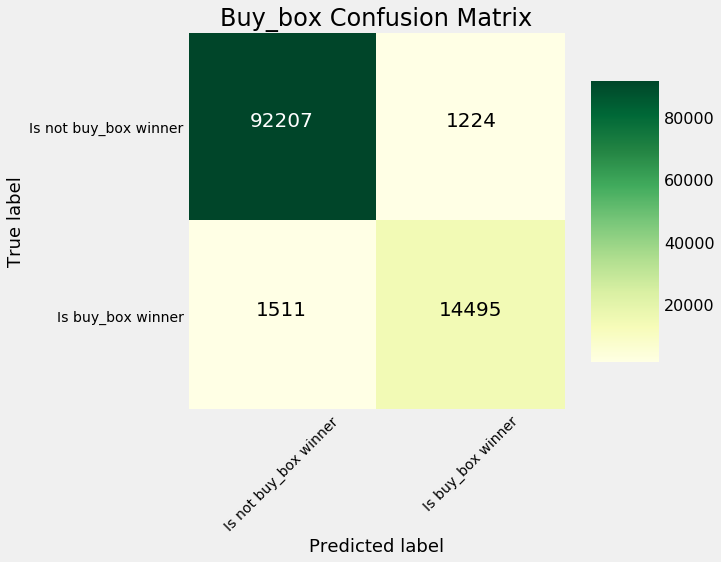

In [176]:
#Not normalized confusion matrix
plot_confusion_matrix(cm, classes = ['Is not buy_box winner', 'Is buy_box winner'],
                      normalize=False,title = 'Buy_box Confusion Matrix')

## Results

**The ROC curves is skyrocketing to 1 at the beginning**. It shows that our model has really good predictions (The best possible prediction method would yield a point in the upper left corner or coordinate (0,1) of the ROC space.) We reach 100% sensitivity (no false negatives) and 100% specificity (no false positives) really quickly.

**the normalize confusion matrix shows that we predicted correctly 99% of non winners and 91% of winners.** This is a good result and it reveals that our model is mostly efficient.

## Plotting Feature Importances

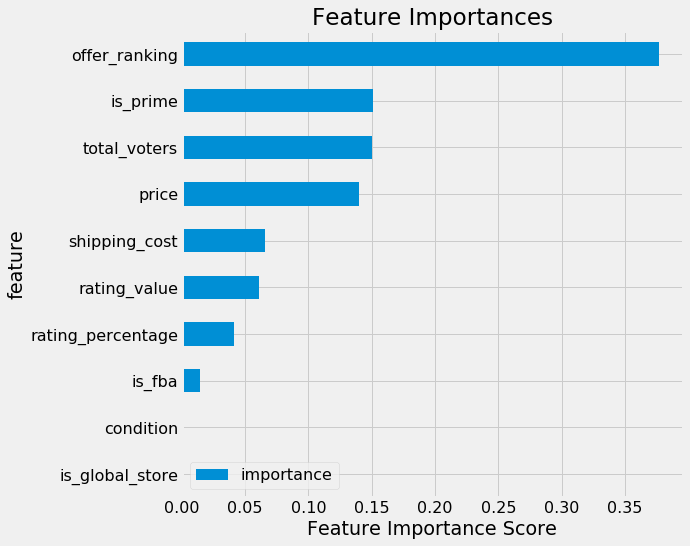

In [177]:
def plot_feature_importances(model, X_train, y_train=None, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    feat_imp = pd.DataFrame({'importance':model.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
plot_feature_importances(model, X_train, y_train=None, top_n=10, figsize=(8,8), print_table=False, title="Feature Importances")

The feature importance barchart underlines interesting information:
 - The most important feature to win the buy_bow (according to our model) **is not the price but the ranking of the seller** on the Amazon Marketplace (price is only the fourth one). The offer ranking is also more than twice the second feature (is_prime).
 - Having a Amazon prime account is the second most important characteristic to win the buy box (equal to the number of voters). **It shows that Amazon is promoting prime accounts on its Marketplace**.
 - The condition characteristic has no importance according to the model.
 - The reputation of  a seller (rating_value and rating_percentage) has not a big impact on the buy box. We usually suppose the opposite. It is also interesting to see that the number of voters is the second most important feature (while having a huge amount of voters doesn't necessarily mean having a good reputation).

## Model improvements in the future

- Create a feature showing for each product, the **difference between the seller’s price and the current lowest price for the product**. I think this feature may be one of the most important characteristic to win the buy_box (we see that the price is not so relevant).
- Show the correlation between reputation (rating_value and rating_percentage) and the number of voters. As we see with this model, the total_voters is more important than reputation. The correlation between those features seems interesting.
- Compare our model with another model (I first thought of Gradient Descent as a model, maybe try this one or another binar classification model)